# Spaceship Titanic

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

### Посмотрю на данные

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.shape

(8693, 14)

Посмотрю на распределение классов

In [4]:
train["Transported"].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

Отлично, классы сбалансированные (не зря метрика в задаче - accuracy). А что с пропусками?

In [5]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Пропусков не так много, CatBoost с этим справится (бустинг над решающими деревьями, которые неплохо обрабатывают пропуски)

## Построю базовую модель

In [6]:
categorical_features = [
    feature for feature, dtype in train.dtypes.items() if dtype == object
]

train[categorical_features] = train[categorical_features].fillna("NA")
test[categorical_features] = test[categorical_features].fillna("NA")

In [7]:
X, y = train.drop(columns=["Transported"]), train["Transported"]
pool = Pool(X, y, cat_features=categorical_features)

In [8]:
baseline_model = CatBoostClassifier(random_seed=26)

baseline_model.fit(pool, logging_level="Silent")

In [9]:
predictions = baseline_model.predict(test)

submission_df = {"PassengerId": test["PassengerId"], "Transported": predictions}
solution = pd.DataFrame(submission_df)
solution.to_csv("baseline_submission.csv", index=False)

Public score на kaggle: 0.79635. Теперь постараюсь улучшить этот результат

## Поработаю с признаками

- Уберу бесполезный признак "PassengerId"

In [10]:
train.drop(columns=["PassengerId"], inplace=True)

test_ids = test["PassengerId"]
test.drop(columns=["PassengerId"], inplace=True)

- Значения "Cabin" имеют вид палуба/номер/борт, так что я разделю этот признак на три

In [11]:
train[["Deck", "Number", "Side"]] = train["Cabin"].str.split("/", expand=True)
test[["Deck", "Number", "Side"]] = test["Cabin"].str.split("/", expand=True)

train.drop(columns=["Cabin"], inplace=True)
test.drop(columns=["Cabin"], inplace=True)

Замечу, что номер комнаты - не самый информативный признак, тем более у него очень много различных значений, так что его тоже уберу

In [12]:
train["Number"].nunique()

1817

In [13]:
train.drop(columns=["Number"], inplace=True)
test.drop(columns=["Number"], inplace=True)

- Признак "Name" очевидно не связан с целевой переменной, но если на борту не слишком много однофамильцев, то можно добавить признак "Family" - количество членов семьи на борту

In [14]:
train["Name"] = train["Name"].str.split().str[-1]
buffer_train = train["Name"].value_counts().reset_index()

test["Name"] = test["Name"].str.split().str[-1]
buffer_test = test["Name"].value_counts().reset_index()

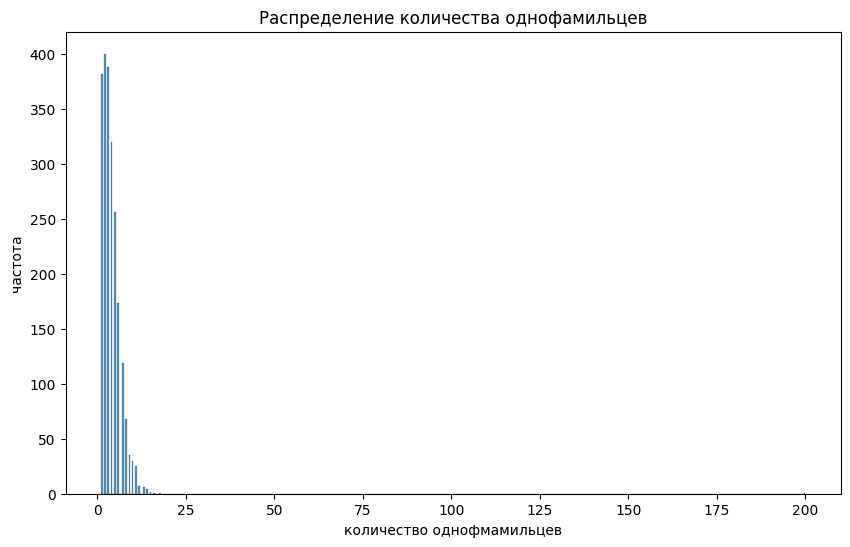

In [15]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(buffer_train["count"])
ax.set(
    title="Распределение количества однофамильцев",
    xlabel="количество однофмамильцев",
    ylabel="частота",
)

plt.show()

Видно, что однофамильцев не бывает слишком много, поэтому скорее всего люди с одной фамилией являются родственниками. Разделю количество родственников по группам: нет/мало/средне/много/очень много (возможно однофамильцы).

In [16]:
def change_family(df, buffer):
    buffer["count"] = np.select(
        [
            buffer["count"] == 1,
            (buffer["count"] >= 2) & (buffer["count"] <= 3),
            (buffer["count"] >= 4) & (buffer["count"] <= 5),
            (buffer["count"] >= 6) & (buffer["count"] <= 7),
            (buffer["count"] > 7),
        ],
        ["no", "small", "average", "big", "else"],
    )

    buffer.rename(columns={"count": "Family"}, inplace=True)

    return pd.merge(df, buffer, on="Name", how="left")

In [17]:
train = change_family(train, buffer_train)
test = change_family(test, buffer_test)

train.drop(columns=["Name"], inplace=True)
test.drop(columns=["Name"], inplace=True)

- Посмотрю на оставшиеся категориальные признаки

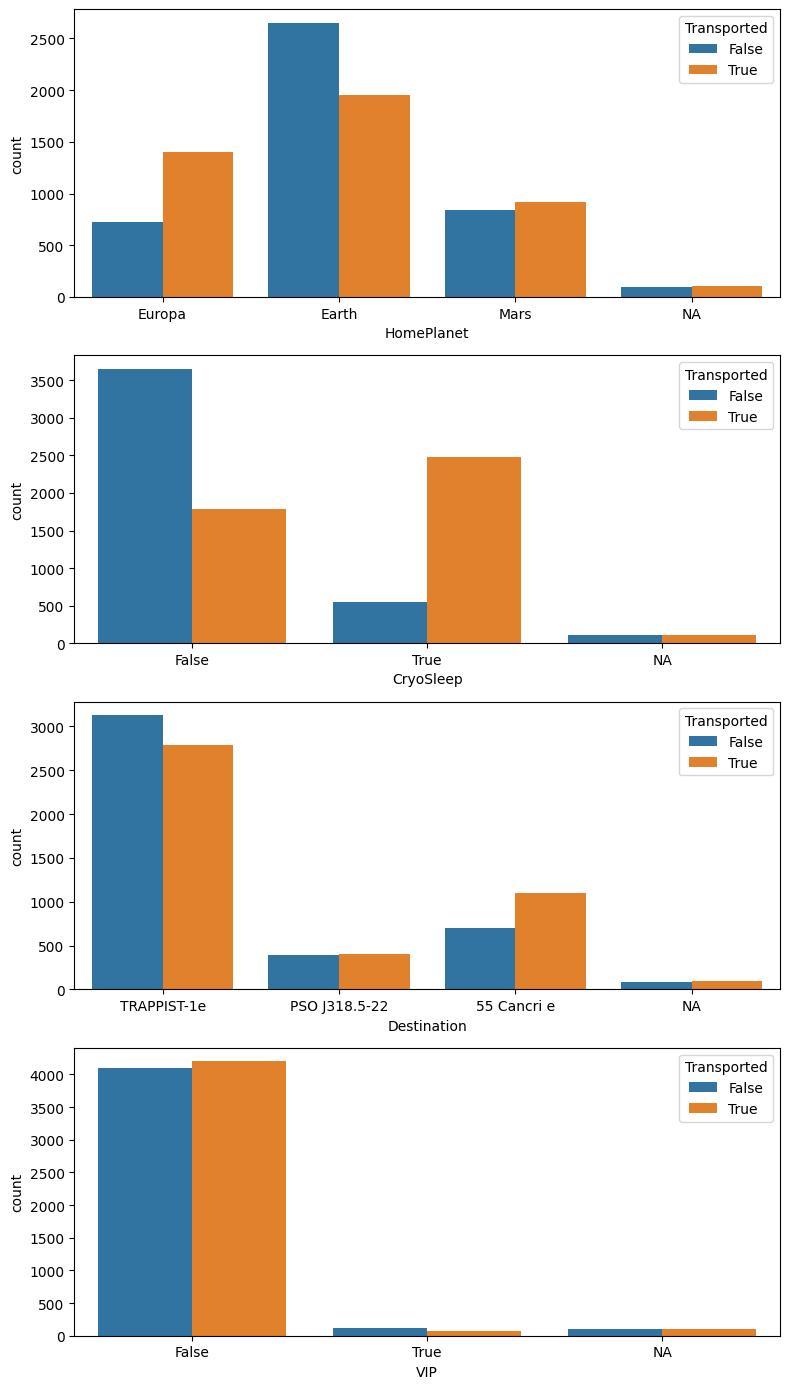

In [18]:
fig = plt.figure(figsize=(8, 14))

for i, name in enumerate(["HomePlanet", "CryoSleep", "Destination", "VIP"]):
    ax = fig.add_subplot(4, 1, i + 1)
    sns.countplot(data=train, x=name, axes=ax, hue="Transported")

fig.tight_layout()
plt.show()

Замечу, что у признака "VIP" целевое распределение практически одинаковое для обоих значений - он бесполезен, уберу этот признак 

In [19]:
train.drop(columns=["VIP"], inplace=True)
test.drop(columns=["VIP"], inplace=True)

- Возраст

Text(0, 0.5, 'кол-во')

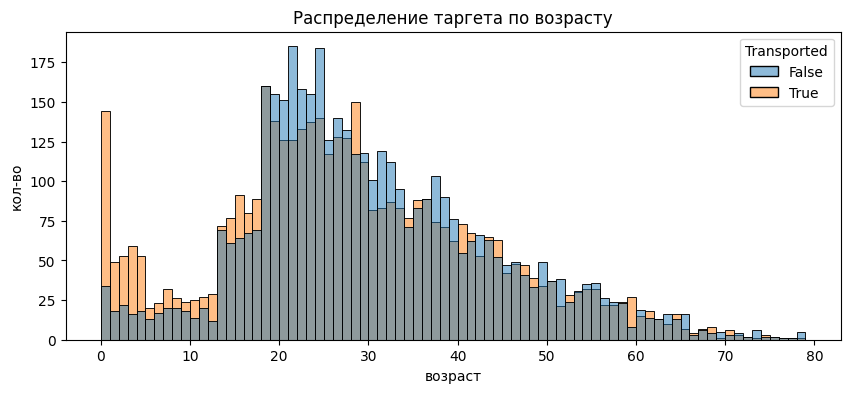

In [20]:
plt.figure(figsize=(10, 4))

sns.histplot(data=train, x="Age", hue="Transported", binwidth=1)

plt.title("Распределение таргета по возрасту")
plt.xlabel("возраст")
plt.ylabel("кол-во")

Здесь можно отследить некоторые закономерности, но ничего делать с признаком не нужно

- Посмотрю на оставшиеся признаки (траты на различные услуги)

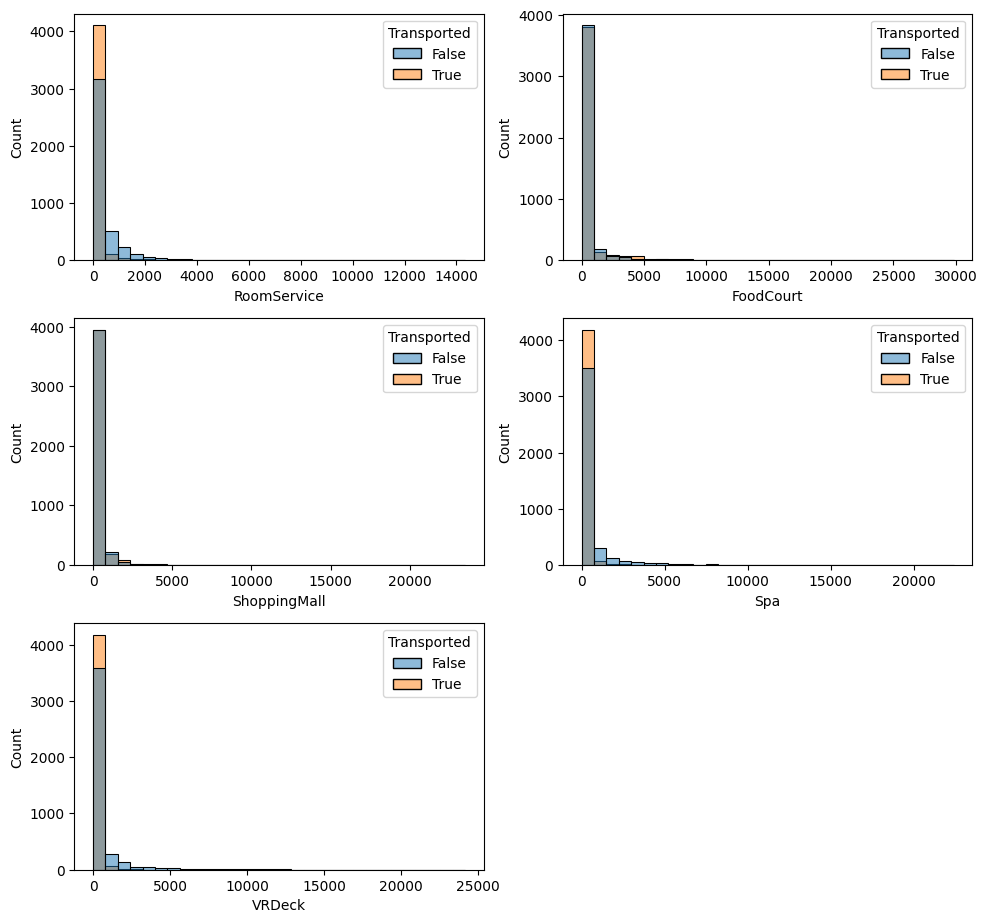

In [21]:
fig = plt.figure(figsize=(10, 15))

for i, var_name in enumerate(
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
):
    ax = fig.add_subplot(5, 2, i + 1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue="Transported")

fig.tight_layout()
plt.show()

Зачему, что большинство пассажиров ничего не потратили - добавлю отдельный признак, отражающий это. Также добавлю признак, в котором будут указаны общие траты

In [22]:
expense_features = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

train["TotalExpenses"] = train[expense_features].sum(axis=1)
train["No_spending"] = (train["TotalExpenses"] == 0).astype(bool)

test["TotalExpenses"] = test[expense_features].sum(axis=1)
test["No_spending"] = (test["TotalExpenses"] == 0).astype(bool)

- В итоге получил вот такой датасет

In [23]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,Family,TotalExpenses,No_spending
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,B,P,no,0.0,True
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,F,S,average,736.0,False
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,S,big,10383.0,False
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,S,big,5176.0,False
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,F,S,big,1091.0,False


## Подберу гиперпараметры

Разделю данные (80/20)

In [24]:
categorical_features = [
    feature for feature, dtype in train.dtypes.items() if dtype == object
]

train[categorical_features] = train[categorical_features].fillna("NA")
test[categorical_features] = test[categorical_features].fillna("NA")

In [25]:
X, y = train.drop(columns=["Transported"]), train["Transported"]
pool = Pool(X, y, cat_features=categorical_features)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)

In [26]:
def objective(trial):
    param = {
        "depth": trial.suggest_int("depth", 4, 10, step=2),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 9),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostClassifier(**param, random_seed=26)
    model.fit(train_pool, eval_set=val_pool, logging_level="Silent", early_stopping_rounds=50)
    predictions = model.predict(val_pool)
    score = accuracy_score(val_pool.get_label(), predictions)

    return score

In [27]:
optuna.logging.disable_default_handler()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

## Сравню финальную модель с базовой

In [28]:
final_model = CatBoostClassifier(**study.best_params, random_seed=26)
final_model.fit(pool, logging_level="Silent")

In [30]:
predictions = final_model.predict(test)

submission_df = {"PassengerId": test_ids, "Transported": predictions}
submission_df["Transported"] = submission_df["Transported"] != 0
solution = pd.DataFrame(submission_df)
solution.to_csv("final_submission.csv", index=False)

Public score на kaggle: 0.80406